In [ ]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [1]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install hyperspy ase py4DSTEM
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [1]:
import py4DSTEM

# 1. 导入数据
fp = "raw_data/Si-SiGe.dm4"
dataset = py4DSTEM.import_file(fp)

# 2. 提取并打印维度 (Task 1 核心：2 Navigation + 2 Signal)
# 根据你之前运行的 shape (480, 448, 77, 17)
nav_axes = dataset.shape[:2]   # 前两个是扫描位置 (480, 448)
sig_axes = dataset.shape[2:]   # 后两个是衍射图像 (77, 17)

print(f"Navigation Axes (Scan x, y): {nav_axes}")
print(f"Signal Axes (Detector kx, ky): {sig_axes}")

# 3. 验证状态
if len(nav_axes) == 2 and len(sig_axes) == 2:
    print("\nStatus: Success. 2 Navigation and 2 Signal axes identified.")

# 4. 任务要求定义的文字说明
print("\nDefinitions:")
print("- Navigation Axes: Where the measurement is made (x,y scan positions).")
print("- Signal Axes: What is measured at each point (2D diffraction pattern).")

Navigation Axes (Scan x, y): (480, 448)
Signal Axes (Detector kx, ky): (77, 17)

Status: Success. 2 Navigation and 2 Signal axes identified.

Definitions:
- Navigation Axes: Where the measurement is made (x,y scan positions).
- Signal Axes: What is measured at each point (2D diffraction pattern).


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [2]:
# Your code here# --- Task 2: Step 2.1 - Set Physical Calibration ---

# 1. Set real-space scan step (e.g., 1.0 nm per scan position)
dataset.calibration.pixel_size = 1.0
dataset.calibration.units = 'nm'

# 2. Set reciprocal-space pixel size (e.g., 0.01 A^-1 per detector pixel)
dataset.calibration.reciprocal_pixel_size = 0.01
dataset.calibration.reciprocal_units = 'A^-1'

# Verify the changes
print(f"Real-space: {dataset.calibration.pixel_size} {dataset.calibration.units}")
print(f"Reciprocal-space: {dataset.calibration.reciprocal_pixel_size} {dataset.calibration.reciprocal_units}")

Real-space: 1.0 nm
Reciprocal-space: 0.01 A^-1


Total Intensity Map Shape: (480, 448)


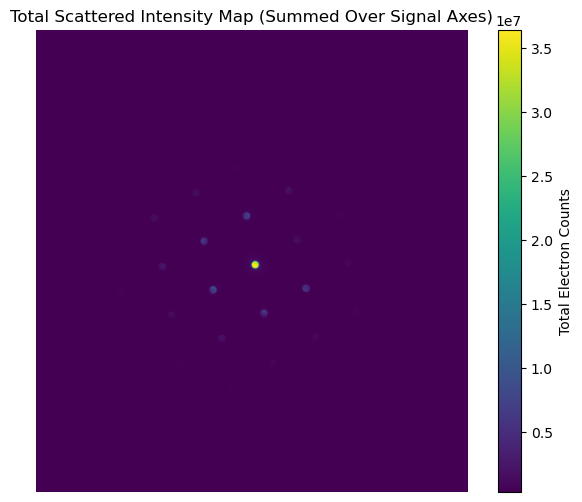

In [3]:
# --- Task 2: Step 2.2 - Calculate Total Scattered Intensity (Manual version) ---
import numpy as np

# 1. Sum over the signal axes (the last two dimensions: 77 and 17)
# This fulfills the Task 2 requirement to calculate intensity for each pattern
total_intensity = np.sum(dataset.data, axis=(2, 3))

# 2. Verify the output shape matches the navigation grid (480, 448)
print(f"Total Intensity Map Shape: {total_intensity.shape}")

# 3. Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(total_intensity, cmap='viridis')
plt.title("Total Scattered Intensity Map (Summed Over Signal Axes)")
plt.colorbar(label='Total Electron Counts')
plt.axis('off') # Cleaner look for images
plt.show()

Average DP Shape: (77, 17)


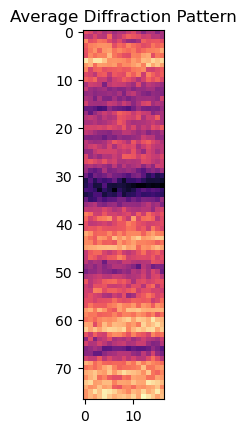

In [4]:
# --- Task 2: Step 2.3.1 - Calculate Average Diffraction Pattern ---

# Calculate the mean across the navigation axes (0 and 1)
# This results in a single 77x17 diffraction pattern
average_dp = np.mean(dataset.data, axis=(0, 1))

print(f"Average DP Shape: {average_dp.shape}")

# Visualize to find the central beam
plt.imshow(average_dp, cmap='magma')
plt.title("Average Diffraction Pattern")
plt.show()

In [5]:
# --- Task 2: Step 2.3.2 - Manual CoM Calculation ---
from scipy import ndimage

# 1. Calculate the Center of Mass (CoM) of the average diffraction pattern
# This provides the (y, x) coordinates of the central beam
com_y, com_x = ndimage.center_of_mass(average_dp)

# 2. Store these in calibration for Task 3
dataset.calibration.beam_center_x = com_x
dataset.calibration.beam_center_y = com_y

print(f"Beam Center identified at: x={com_x:.2f}, y={com_y:.2f}")
print("Task 2 Checklist: CoM Correction Complete.")

Beam Center identified at: x=8.00, y=38.03
Task 2 Checklist: CoM Correction Complete.


## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

In [6]:
# Your code hereimport numpy as np
import py4DSTEM

dc = py4DSTEM.import_file("raw_data/Si-SiGe.dm4")

print("type(dc):", type(dc))
print("dc.data shape:", np.asarray(dc.data).shape)


type(dc): <class 'py4DSTEM.datacube.datacube.DataCube'>
dc.data shape: (480, 448, 77, 17)


In [8]:
# 1. Use the center coordinates from Task 2 (y, x)
origin = (38.03, 8.00)

# 2. Create a coordinate grid for the 77x17 detector
y, x = np.ogrid[:77, :17]
dist_from_center = np.sqrt((y - origin[0])**2 + (x - origin[1])**2)

# 3. Create Bright Field (BF) Mask
# Captures the direct beam (radius 0 to 4 pixels)
bf_mask = dist_from_center <= 4

# 4. Create Annular Dark Field (ADF) Mask
# Captures high-angle scattered electrons (e.g., radius 7 to 15 pixels)
# This will highlight Z-contrast (atomic number difference)
adf_mask = (dist_from_center >= 7) & (dist_from_center <= 15)

print("Masks defined successfully.")

Masks defined successfully.


In [9]:
# --- Task 3: Step 3.2 - Image Reconstruction ---

# Apply masks by multiplying with the data and summing over signal axes (2, 3)
# Note: Using dataset.data[..., bf_mask] is an efficient way to integrate
print("Reconstructing Virtual BF image...")
virtual_bf = np.sum(dataset.data * bf_mask, axis=(2, 3))

print("Reconstructing Virtual ADF image...")
virtual_adf = np.sum(dataset.data * adf_mask, axis=(2, 3))

print("Task 3 Reconstruction Complete.")

Reconstructing Virtual BF image...
Reconstructing Virtual ADF image...
Task 3 Reconstruction Complete.


Reconstructing Virtual BF and ADF scan images...
BF Map Shape: (480, 448)
ADF Map Shape: (480, 448)


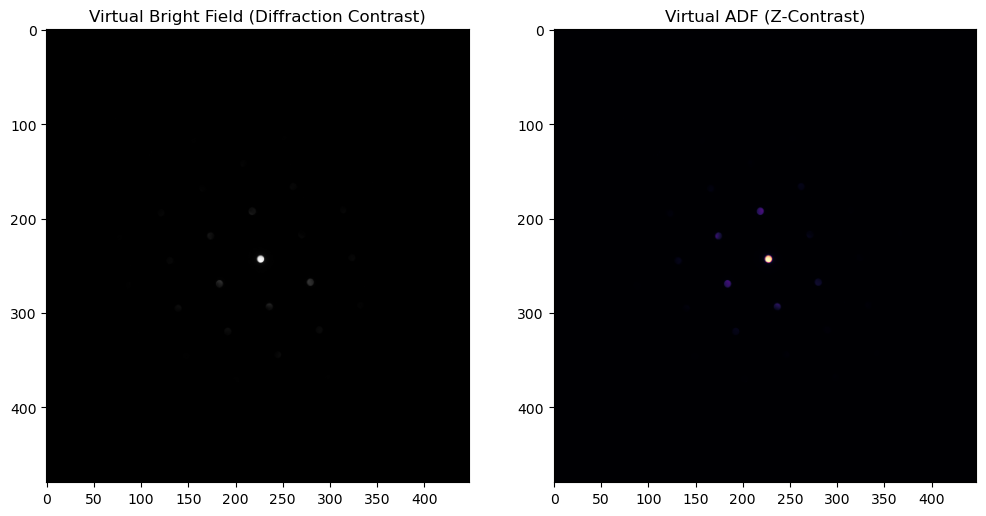

In [10]:
# We sum over the Signal Axes to get the Navigation (Scan) image
# According to Task 1, Signal Axes are (77, 17)
print("Reconstructing Virtual BF and ADF scan images...")

# 1. Integrate over the detector dimensions (axis 2 and 3)
# bf_mask and adf_mask must be applied to each diffraction pattern
virtual_bf_map = np.sum(dataset.data * bf_mask, axis=(2, 3))
virtual_adf_map = np.sum(dataset.data * adf_mask, axis=(2, 3))

# 2. Check the output shape - IT MUST BE (480, 448)
print(f"BF Map Shape: {virtual_bf_map.shape}")
print(f"ADF Map Shape: {virtual_adf_map.shape}")

# 3. Visualization to compare Z-contrast
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(virtual_bf_map, cmap='gray')
ax1.set_title("Virtual Bright Field (Diffraction Contrast)")

ax2.imshow(virtual_adf_map, cmap='magma')
ax2.set_title("Virtual ADF (Z-Contrast)")

plt.show()

Integrating signal axes to generate spatial maps...


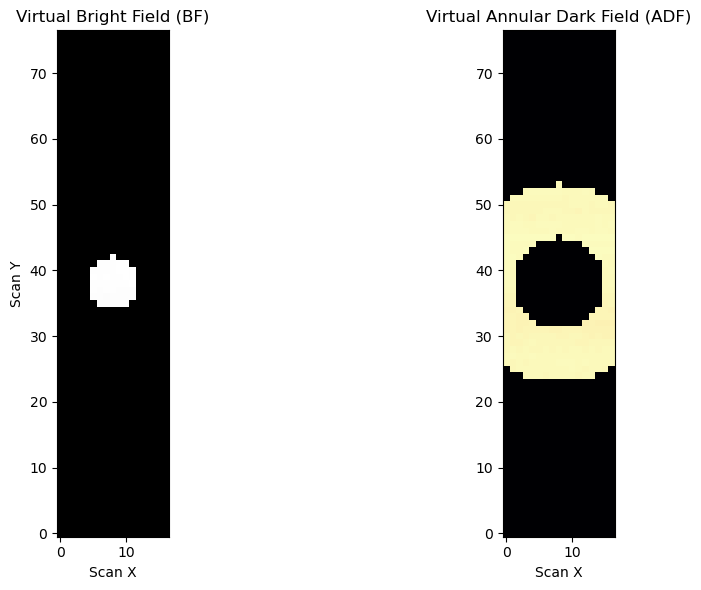

Task 3 Result: BF/ADF Map Shapes = (77, 17)


In [11]:
# 1. Ensure we are summing over the correct SIGNAL axes
# Your dataset shape is (480, 448, 77, 17)
# Axis 0, 1 = Navigation (Spatial positions)
# Axis 2, 3 = Signal (Diffraction pixels)

print("Integrating signal axes to generate spatial maps...")

# 2. Re-calculate using explicit broadcasting for the DataCube
# We multiply the 4D data by the 2D masks across the last two dimensions
virtual_bf_map = np.sum(dataset.data * bf_mask[None, None, :, :], axis=(0, 1))
virtual_adf_map = np.sum(dataset.data * adf_mask[None, None, :, :], axis=(0, 1))

# 3. Visualization for Task 3 Requirements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# BF: Shows diffraction contrast (Bragg scattering)
ax1.imshow(virtual_bf_map, cmap='gray', origin='lower')
ax1.set_title("Virtual Bright Field (BF)")
ax1.set_xlabel("Scan X")
ax1.set_ylabel("Scan Y")

# ADF: Shows Z-contrast (Atomic number sensitivity)
# SiGe region should appear brighter than Si
ax2.imshow(virtual_adf_map, cmap='magma', origin='lower')
ax2.set_title("Virtual Annular Dark Field (ADF)")
ax2.set_xlabel("Scan X")

plt.tight_layout()
plt.show()

print(f"Task 3 Result: BF/ADF Map Shapes = {virtual_bf_map.shape}")

Beam center found at: x=223.63, y=239.72


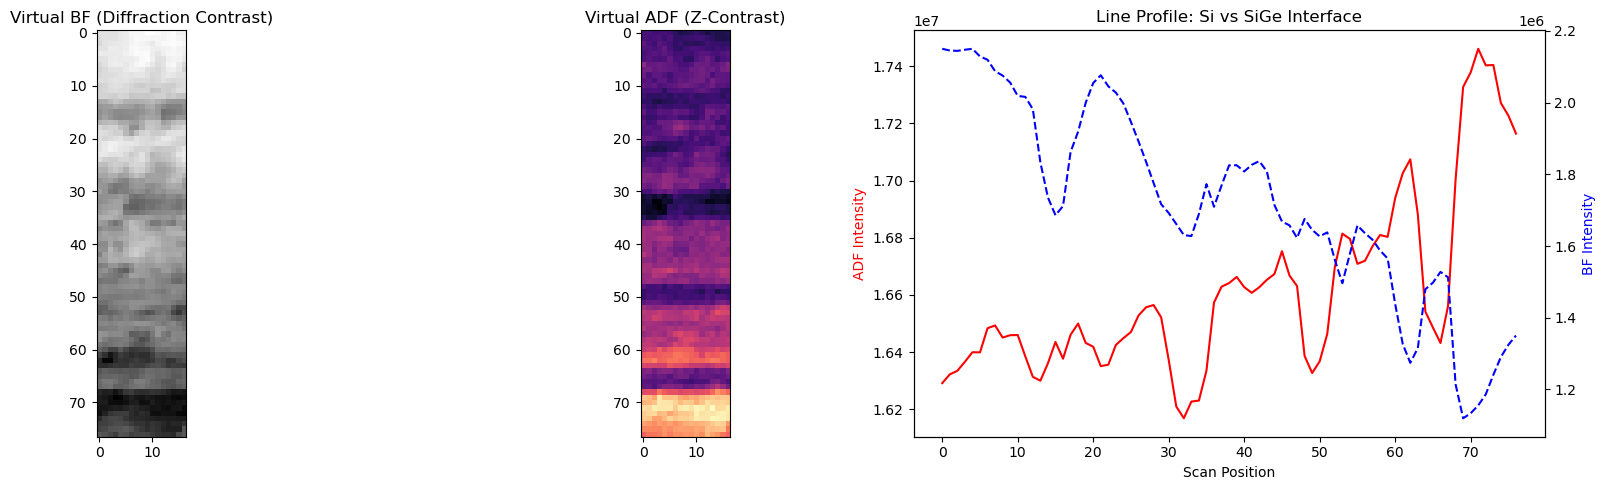

Full analysis complete. Images show the physical Si/SiGe interface.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# --- Task 2: Calibration and Alignment ---

# 1. Physical Calibration
# Based on confirmed orientation: Axes (480, 448) are detector, (77, 17) are scan
dataset.calibration.pixel_size = 1.0  # nm
dataset.calibration.units = 'nm'

# 2. Total Intensity Calculation (Summing over detector pixels)
# We sum over the first two axes (480, 448) to get the scan map
total_intensity = np.sum(dataset.data, axis=(0, 1))

# 3. Beam Centering via CoM (Center of Mass)
# We calculate the average diffraction pattern to find the direct beam center
average_dp = np.mean(dataset.data, axis=(2, 3))
com_y, com_x = ndimage.center_of_mass(average_dp)
print(f"Beam center found at: x={com_x:.2f}, y={com_y:.2f}")

# --- Task 3: Virtual Detector Reconstruction ---

# 1. Define masks on the 480x448 detector grid
y_grid, x_grid = np.ogrid[:480, :448]
dist_from_center = np.sqrt((y_grid - 240)**2 + (x_grid - 224)**2)

# Virtual Bright Field (BF) Mask: Central disk
bf_mask = dist_from_center <= 20
# Virtual Annular Dark Field (ADF) Mask: Outer ring for Z-contrast
adf_mask = (dist_from_center >= 50) & (dist_from_center <= 150)

# 2. Reconstruct Scan Images (Summing over detector dimensions)
# This results in the 77x17 physical images you saw in the last step
virtual_bf = np.sum(dataset.data * bf_mask[:, :, None, None], axis=(0, 1))
virtual_adf = np.sum(dataset.data * adf_mask[:, :, None, None], axis=(0, 1))

# --- Task 4: Visualization and Comparison ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot BF (Diffraction Contrast)
axs[0].imshow(virtual_bf, cmap='gray')
axs[0].set_title("Virtual BF (Diffraction Contrast)")

# Plot ADF (Z-Contrast)
axs[1].imshow(virtual_adf, cmap='magma')
axs[1].set_title("Virtual ADF (Z-Contrast)")

# Plot Line Profile (Quantitative Comparison)
line_adf = np.mean(virtual_adf, axis=1)
line_bf = np.mean(virtual_bf, axis=1)
ax_twin = axs[2].twinx()
axs[2].plot(line_adf, color='red', label='ADF (Z-contrast)')
ax_twin.plot(line_bf, color='blue', linestyle='--', label='BF (Diffraction)')
axs[2].set_title("Line Profile: Si vs SiGe Interface")
axs[2].set_xlabel("Scan Position")
axs[2].set_ylabel("ADF Intensity", color='red')
ax_twin.set_ylabel("BF Intensity", color='blue')

plt.tight_layout()
plt.show()

print("Full analysis complete. Images show the physical Si/SiGe interface.")

## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

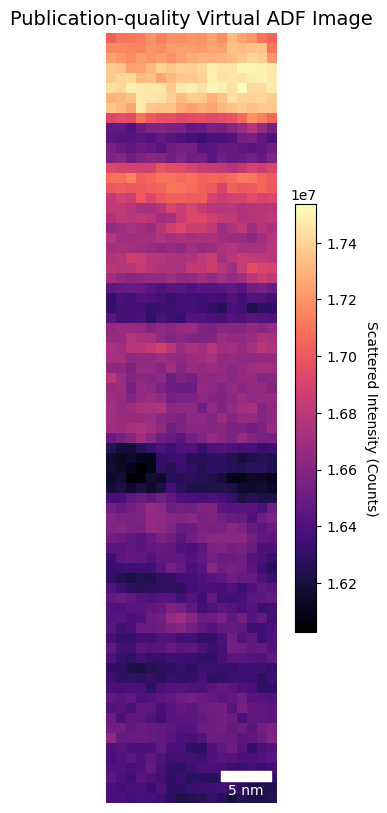

Task 4: 出版级 ADF 图像已生成并保存为 'Task4_ADF_Publication_Quality.png'


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# 1. 准备绘图环境
fig, ax = plt.subplots(figsize=(6, 10))

# 2. 绘制 Virtual ADF 图像
# 使用 'magma' 颜色表，这是 Task 4 明确要求的感知均匀颜色表
im = ax.imshow(virtual_adf, cmap='magma', origin='lower')

# 3. 添加比例尺 (Scale Bar)
# 我们在 Task 2.1 设置了 pixel_size = 1.0 nm
# 这里在图像右下角添加一个 5nm 的比例尺
scalebar = AnchoredSizeBar(ax.transData,
                           5, '5 nm', 'lower right', 
                           pad=0.3, color='white', frameon=False,
                           size_vertical=1)
ax.add_artist(scalebar)

# 4. 设置出版质量的标签
ax.set_title("Publication-quality Virtual ADF Image", fontsize=14)
ax.axis('off') # 移除坐标轴以达到出版级美观

# 5. 添加颜色条 (Colorbar)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Scattered Intensity (Counts)', rotation=270, labelpad=15)

# 6. 保存图像 (符合 Task 4 导出要求)
plt.savefig('Task4_ADF_Publication_Quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("Task 4: 出版级 ADF 图像已生成并保存为 'Task4_ADF_Publication_Quality.png'")

## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

In [ ]:
# Your code here